In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ttim as tt
import timml as tm

### Example 4
Aquifer storage and recovery

In [2]:
# parameters
Q = 100 # discharge of well, m^3/d
k = 10 # hydraulic conductivity, m/d
H = 10 # thickness of aquifer, m
Ss = 1e-4 # specific storage, m^(-1)
npor = 0.1 # porosity, -
xw = 0 # x-location of well
yw = 0 # y-location of well
rw = 0.01 # radius of well

In [3]:
ml = tt.ModelMaq(kaq=[k], z=[H, 0], Saq=[Ss], poraq=[npor], tmin=0.001, tmax=1000, M=10)
w = tt.Well(ml, xw=0, yw=0, tsandQ=[(0, -Q)], rw=rw)
ml.solve()

self.neq  1
solution complete


In [4]:
ml = tt.ModelMaq(kaq=[k], z=[H, 0], Saq=[Ss], poraq=[npor], tmin=0.001, tmax=1000, M=10)
w = tt.Well(ml, xw=0, yw=0, tsandQ=[(0, -Q), (100, Q)], rw=rw)
ml.solve()

self.neq  1
solution complete


In [5]:
ml.head(10, 0, 100 - 1e-6)

array([[0.98055413]])

In [10]:
ml.head(10, 0, 100 + 1e-3)

array([[0.8143499]])

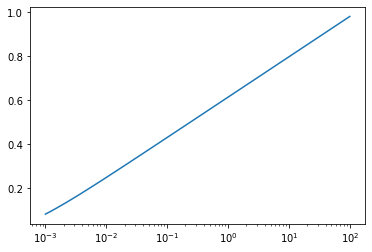

In [15]:
t = np.logspace(-3, 2, 100)
h = ml.head(10, 0, t)
plt.semilogx(t, h[0])

In [8]:
ml.head(10, 0, [90, 100, 110])

array([[ 0.97216983,  0.98055414, -0.60650735]])

In [58]:
trace = tt.timtrace(ml, xstart=rw, ystart=0, zstart=0.5 * H, tstartend=[0, 100], 
                    tstartoffset=0.001, tstep=0.1, hstepmax=2, nstepmax=2000)

reached maximum time tmax


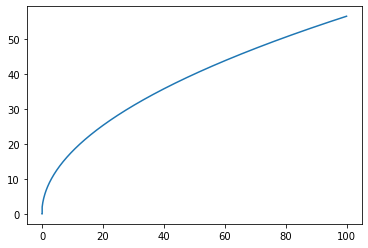

In [59]:
xyzt = trace['xyzt']
plt.plot(xyzt[:, 3], xyzt[:, 0])

In [60]:
ml = tt.ModelMaq(kaq=[k], z=[H, 0], Saq=[Ss], poraq=[npor], tmin=0.001, tmax=1000, M=10)
w = tt.Well(ml, xw=0, yw=0, tsandQ=[(0, -Q), (100, Q)], rw=rw)
ml.solve()
trace = tt.timtrace(ml, xstart=rw, ystart=0, zstart=0.5 * H, tstartend=[0, 0.1, 1, 100], 
                    tstartoffset=0.001, tstep=[0.01, 0.1, 1], hstepmax=2, nstepmax=2000)

self.neq  1
solution complete
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax


In [61]:
xend, yend, zend, tend = trace['xyzt'][-1]

In [62]:
def integrand(r, t=100 - 1e-6):
    h = ml.head(r, 0, t)
    return h[0, 0] * 2 * np.pi * r * ml.aq.Saq[0]

In [63]:
ml.aq.Saq

array([0.0001])

In [70]:
from scipy.integrate import quad
np.pi * xend ** 2 * ml.aq.Haq[0] * ml.aq.poraq[0] + quad(integrand, rw, xend)[0]

10007.366405521809

In [65]:
np.pi * rw ** 2 * ml.aq.Haq[0] * ml.aq.poraq[0]

0.0003141592653589793

In [98]:
ml.tintervals

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

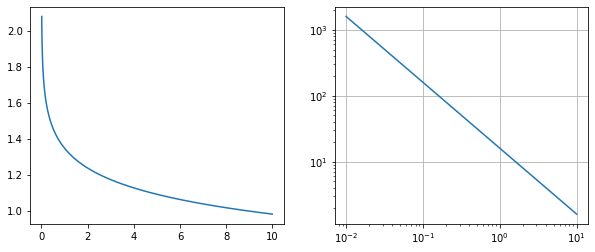

In [79]:
r = np.logspace(-2, 1, 100)
h = ml.headalongline(r, 0, t=100 - 1e-6)
Qx = [ml.disvec(x, 0, t=100 - 1e-6)[0][0, 0] for x in r]
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(r, h[0, 0])
plt.subplot(122)
plt.loglog(r, Qx)
plt.grid()

In [82]:
from scipy.integrate import solve_ivp
solve_ivp??

Signature:
solve_ivp(
    fun,
    t_span,
    y0,
    method='RK45',
    t_eval=None,
    dense_output=False,
    events=None,
    vectorized=False,
    args=None,
    **options,
)
Source:   
def solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False,
              events=None, vectorized=False, args=None, **options):
    """Solve an initial value problem for a system of ODEs.

    This function numerically integrates a system of ordinary differential
    equations given an initial value::

        dy / dt = f(t, y)
        y(t0) = y0

    Here t is a 1-D independent variable (time), y(t) is an
    N-D vector-valued function (state), and an N-D
    vector-valued function f(t, y) determines the differential equations.
    The goal is to find y(t) approximately satisfying the differential
    equations, given an initial value y(t0)=y0.

    Some of the solvers support integration in the complex domain, but note
    that for stiff ODE solvers, the right-hand side must 

### Pathline tracing

Pathlines are computed through numerical integration of the velocity vector. Pathlines are computed with the `timtrace` function. The `timtrace` function takes as input arguments the starting locations of the pathline (`xstart`, `ystart`, `zstart`), a list with the starting time and end time of the pathline (`tstartend`), a time offset (`tstartoffset`), and a maximum time step (`tstep`). The pathline starts at the starting time plus the time offset (`tstartoffset`). When the starting time is at the time of a change in boundary condition (e.g., a well starts pumping), the time offset can not be smaller than `tmin`. The `timtrace` function has several keyword arguments to affect the numerical integration procedure. The `hstepmax` keyword is used here, which is the maximum horizontal step (in the length units consistently used throughout the model). 

The `timtrace` function returns a dictionary with three three entries:

- `'xyzt'` : 2D array with four columns: x, y, z, t along pathline
- `'message'` : list with text messages of each section of the pathline
- `'status'` : numerical indication of the result. Negative is likely undesirable.
    
The status can be one of the following:
- -2 : reached maximum number of steps before reaching maximum time
- -1 : starting z value not inside aquifer
- +1 : reached maximum time
- +2 : reached element   

The `message` is automatically printed to the screen unless the keyword `silent` is set to `True`. 

### Example 1
Consider a well that starts pumping at $t=0$ in a confined aquifer. The well is located at the origin of the coordinate system.

In [2]:
# parameters
Q = 100 # discharge of well, m^3/d
k = 10 # hydraulic conductivity, m/d
H = 10 # thickness of aquifer, m
Ss = 1e-4 # specific storage, m^(-1)
npor = 0.3 # porosity, -
xw = 0 # x-location of well
yw = 0 # y-location of well
rw = 0.3 # radius of well

In [3]:
ml = tt.ModelMaq(kaq=[k], z=[H, 0], Saq=[Ss], tmin=0.001, tmax=1000, M=10)
w = tt.Well(ml, xw=0, yw=0, tsandQ=[(0, Q)], rw=rw)
ml.solve()

self.neq  1
solution complete


A pathline is started at $(x,y,z)=(10, 10, 5)$ and followed for 10 days. 

In [34]:
trace = tt.timtrace(ml, xstart=10, ystart=10, zstart=0.5 * H, tstartend=[0, 10], 
                    tstartoffset=0.001, tstep=1, hstepmax=2)

reached maximum time tmax


The output of the `timtrace` function is stored in the `trace` dictionary. The entries of the dictionary are printed below. Note that the pathline starts at $t=0.001$ d, which is the specified `tstartoffset`, that steps are taken with a length of 1 day, and that the pathline is terminated when the maximum time of 10 days is reached. 

In [5]:
print('xyzt array of pathline:')
print(trace['xyzt'])
print('trace message:', trace['message'])
print('trace status:', trace['status'])

xyzt array of pathline:
[[1.00000000e+01 1.00000000e+01 5.00000000e+00 0.00000000e+00]
 [1.00000000e+01 1.00000000e+01 5.00000000e+00 1.00000000e-03]
 [9.78472212e+00 9.78472212e+00 5.00000000e+00 1.00100000e+00]
 [9.50986380e+00 9.50986380e+00 5.00000000e+00 2.00100000e+00]
 [9.22677289e+00 9.22677289e+00 5.00000000e+00 3.00100000e+00]
 [8.93469839e+00 8.93469839e+00 5.00000000e+00 4.00100000e+00]
 [8.63273762e+00 8.63273762e+00 5.00000000e+00 5.00100000e+00]
 [8.31981832e+00 8.31981832e+00 5.00000000e+00 6.00100000e+00]
 [7.99465612e+00 7.99465612e+00 5.00000000e+00 7.00100000e+00]
 [7.65569276e+00 7.65569276e+00 5.00000000e+00 8.00100000e+00]
 [7.30100747e+00 7.30100747e+00 5.00000000e+00 9.00100000e+00]
 [6.93806421e+00 6.93806421e+00 5.00000000e+00 1.00000000e+01]]
trace message: ['reached maximum time tmax']
trace status: [1]


When the pathline is computed for a max of 20 days (i.e., the last entry in `tstartend` equals 20), the well is reached before $t=20$ d is reached

In [16]:
trace = tt.timtrace(ml, xstart=10, ystart=10, zstart=0.5 * H, tstartend=[0, 20], 
                    tstartoffset=0.001, tstep=1, hstepmax=2)

reached element of type well: Well at (0.0, 0.0)


In [17]:
print('last two entries in xyzt:')
print(trace['xyzt'][-2:])

last two entries in xyzt:
[[ 0.94871432  0.94871432  5.         18.8683065 ]
 [ 0.          0.          5.         19.20762075]]


When the horizontal stepsize is larger than the specified `hstepmax` value, the timestep is reduced. For example, specifying `hstepmax=0.5` and following the pathline for 4 days gives

In [31]:
trace = tt.timtrace(ml, xstart=10, ystart=10, zstart=0.5 * H, tstartend=[0, 1], 
                    tstartoffset=0.001, tstep=1, hstepmax=0.1)

reached maximum time tmax


In [29]:
xyzt = trace['xyzt']
print('xyzt:')
print(trace['xyzt'])
x0, y0, z0, t0 = xyzt[1]
x1, y1, z1, t1 = xyzt[2]
print(f'length of first step: {np.sqrt((x1 - x0) ** 2 + (y1 - y0) ** 2):.2f}')

xyzt:
[[1.00000000e+01 1.00000000e+01 5.00000000e+00 0.00000000e+00]
 [1.00000000e+01 1.00000000e+01 5.00000000e+00 1.00000000e-03]
 [9.92928932e+00 9.92928932e+00 5.00000000e+00 3.31474847e-01]
 [9.85857864e+00 9.85857864e+00 5.00000000e+00 5.95520257e-01]
 [9.78786797e+00 9.78786797e+00 5.00000000e+00 8.57557196e-01]
 [9.74928649e+00 9.74928649e+00 5.00000000e+00 1.00000000e+00]]
length of first step: 0.10


The other keyword arguments are `nstepmax=100`, `silent=False`, and `correctionstep=True`. The `nstepmax` is the maximum number of steps. Numerical integration stops when the maximum number of steps is reached and the returned `status` is `-2`. For most practical cases, this is an undesirable result and the maximum number of steps should be increased. Setting `silent=True` prevents the message from being printed to the screen, which may be useful when a lot of pathlines are computed, for example in a loop. When the `correctionstep` is set to `True` (default), the numerical integration scheme is a predictor-correcter scheme. When `correctionstep` is set to `False`, the integration scheme is forward integration through time, which is less accurate but quicker. 

### Example 2
Consider a well in a confined aquifer. The well starts pumping with discharge $Q$ at time $t=0$ and starts injection with discharge $Q$ at time $t=10$ d. The well is located at the origin of the coordinate system.

In [39]:
ml = tt.ModelMaq(kaq=[k], z=[H, 0], Saq=[Ss], tmin=0.001, tmax=1000, M=10)
w = tt.Well(ml, xw=0, yw=0, tsandQ=[(0, Q), (10, -Q)], rw=rw)
ml.solve()

self.neq  1
solution complete


A pathline is started at $(x,y,z)=(10, 10, 5)$ and followed for 20 days. The `tstartend` list is now `[0, 10, 20]` and `tstartoffset=0.001`. This means that the pathline consists of two sections. The first section starts at $t=0.001$ d and is followed up till $t=10$ d. The second section starts  at $t=10.001$ d (from the endpoint at $t=10$ d of the first section) and is followed up till $t=20$ d. The `nstepmax` keyword is the maximum number of steps for each section of the pathline. There are two messages printed to the screen, one for each section. 

In [47]:
trace = tt.timtrace(ml, xstart=10, ystart=10, zstart=0.5 * H, tstartend=[0, 10, 20], 
                    tstartoffset=0.001, tstep=1, hstepmax=2)

reached maximum time tmax
reached maximum time tmax


The $x,y,z,t$ array is printed below. Note that the first section ends at $t=10$ d. 
After 20 d, the pathline ends at (almost) the same location as it started. The small discrepancy is caused by numerical error of the integration scheme and by the increase in storage that is neglected.

In [50]:
xyzt = trace['xyzt']
print('xyzt:')
print(trace['xyzt'])

xyzt:
[[1.00000000e+01 1.00000000e+01 5.00000000e+00 0.00000000e+00]
 [1.00000000e+01 1.00000000e+01 5.00000000e+00 1.00000000e-03]
 [9.78472212e+00 9.78472212e+00 5.00000000e+00 1.00100000e+00]
 [9.50986380e+00 9.50986380e+00 5.00000000e+00 2.00100000e+00]
 [9.22677289e+00 9.22677289e+00 5.00000000e+00 3.00100000e+00]
 [8.93469839e+00 8.93469839e+00 5.00000000e+00 4.00100000e+00]
 [8.63273762e+00 8.63273762e+00 5.00000000e+00 5.00100000e+00]
 [8.31981832e+00 8.31981832e+00 5.00000000e+00 6.00100000e+00]
 [7.99465612e+00 7.99465612e+00 5.00000000e+00 7.00100000e+00]
 [7.65569276e+00 7.65569276e+00 5.00000000e+00 8.00100000e+00]
 [7.30100747e+00 7.30100747e+00 5.00000000e+00 9.00100000e+00]
 [6.93806421e+00 6.93806421e+00 5.00000000e+00 1.00000000e+01]
 [6.93806421e+00 6.93806421e+00 5.00000000e+00 1.00010000e+01]
 [7.23288902e+00 7.23288902e+00 5.00000000e+00 1.10010000e+01]
 [7.59064546e+00 7.59064546e+00 5.00000000e+00 1.20010000e+01]
 [7.93233482e+00 7.93233482e+00 5.00000000e+00 1.

### Example 3
Consider an injection well in a semi-confined aquifer. The well starts injecting with discharge $Q$ at time $t=0$ and starts injection with discharge $Q$ at time $t=10$ d. The well is located at the origin of the coordinate system. 

In [2]:
# parameters
k = 20 # hydraulic conductivity aquifer, m/d
H = 10 # thickness of aquifers, m
Hstar = 2 # thickness of leaky layer, m
c = 100 # resistance of leaky layer, d
Ss = 1e-4 # specific storage of both aquifers, m^(-1)
npor = 0.3 # porosity of both aquifers, -
Q = 1000 # discharge of well in aquifer 1, m^3/d
xw = 0 # x-location of well
yw = 0 # y-location of well
rw = 0.3 # radius of well

In [3]:
ml = tt.ModelMaq(kaq=[k], z=[H + Hstar, H, 0], c=[c], Saq=Ss, 
                 topboundary='semi', tmin=0.001, tmax=1000, M=10)
w = tt.Well(ml, xw=0, yw=0, tsandQ=[(0, -Q)], layers=0, rw=0.3)
ml.solve()

self.neq  1
solution complete


Nine pathlines are started at the well screen at different elevations in the aquifer and followed for a max of 1000 days. Five of the nine pathlines end at the top of the semi-confining layer within the 1000 days (the five pathlines that start at the highest elevations).

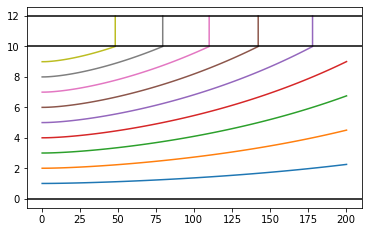

In [10]:
plt.subplot(111, aspect=10)
zstart = np.arange(1.0, 10, 1)
for zs in zstart:
    trace = tt.timtrace(ml, xstart=rw, ystart=0, zstart=zs, 
                        tstartend=[0, 1000], tstartoffset=0.01, tstep=100, 
                        nstepmax=100, hstepmax=2, silent=True)
    xyzt = trace['xyzt']
    plt.plot(xyzt[:, 0], xyzt[:, 2])
for y in [0, H, H + Hstar]:
    plt.axhline(y, color='k')

In [15]:
ml.head(5, 5, 5, layers=0).shape

(1, 1)

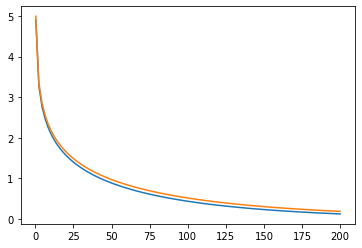

In [128]:
x = np.linspace(rw, 200, 100)
h = ml.headalongline(x, 0, 0.1)
plt.plot(x, h[0, 0])
h = ml.headalongline(x, 0, 1)
plt.plot(x, h[0, 0])

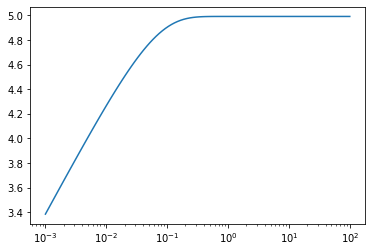

In [123]:
t = np.logspace(-3, 2, 100)
h = w.headinside(t)
plt.semilogx(t, h[0])

In [116]:
np.sqrt(k * H * c)

141.4213562373095

In [104]:
# parameters
k0 = 20 # hydraulic conductivity aquifer 0, m/d
k1 = 40 # hydraulic conductivity aquifer 1, m/d
H = 10 # thickness of both aquifers, m
Hstar = 2 # thickness of leaky layer, m
c = 100 # resistance of leaky layer, d
Ss = 1e-4 # specific storage of both aquifers, m^(-1)
npor = 0.3 # porosity of both aquifers, -
Q = 100 # discharge of well in aquifer 1, m^3/d
xw = 0 # x-location of well
yw = 0 # y-location of well
rw = 0.3 # radius of well

In [105]:
ml = tt.ModelMaq(kaq=[k0, k1], z=[H + Hstar + H, H + Hstar, H, 0], c=[c], Saq=[Ss, Ss], 
                 tmin=0.01, tmax=10000, M=10)
w = tt.Well(ml, xw=0, yw=0, tsandQ=[(0, Q)], layers=1, rw=0.3)
ml.solve()

self.neq  1
solution complete


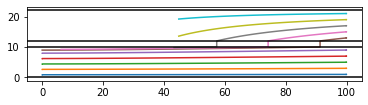

In [108]:
zstart = np.hstack((np.arange(1, 10, 2), np.arange(13, 22, 2)))
for zs in zstart:
    trace = tt.timtrace(ml, xstart=100, ystart=0, zstart=zs, 
                        tstartend=[0, 10000], tstartoffset=0.01, tstep=100, 
                        nstepmax=100, hstepmax=2, silent=True)
    xyzt = trace['xyzt']
    plt.plot(xyzt[:, 0], xyzt[:, 2])
for y in [0, H, H + Hstar, H + Hstar + H]:
    plt.axhline(y, color='k')
plt.axis('scaled');

In [110]:
trace = tt.timtrace(ml, xstart=100, ystart=0, zstart=1, 
                        tstartend=[0, 10000], tstartoffset=0.01, tstep=100, 
                        nstepmax=100, hstepmax=2, silent=True)
trace['xyzt']

array([[1.00000000e+02, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+02, 0.00000000e+00, 1.00000000e+00, 1.00000000e-02],
       [9.80000000e+01, 0.00000000e+00, 9.97471846e-01, 5.32099582e+01],
       [9.60000000e+01, 0.00000000e+00, 9.94584121e-01, 9.42742075e+01],
       [9.40000000e+01, 0.00000000e+00, 9.91698424e-01, 1.34373621e+02],
       [9.20000000e+01, 0.00000000e+00, 9.88815329e-01, 1.73514044e+02],
       [9.00000000e+01, 0.00000000e+00, 9.85935620e-01, 2.11700770e+02],
       [8.80000000e+01, 0.00000000e+00, 9.83060151e-01, 2.48938970e+02],
       [8.60000000e+01, 0.00000000e+00, 9.80189832e-01, 2.85233771e+02],
       [8.40000000e+01, 0.00000000e+00, 9.77325613e-01, 3.20590297e+02],
       [8.20000000e+01, 0.00000000e+00, 9.74468487e-01, 3.55013678e+02],
       [8.00000000e+01, 0.00000000e+00, 9.71619485e-01, 3.88509052e+02],
       [7.80000000e+01, 0.00000000e+00, 9.68779680e-01, 4.21081569e+02],
       [7.60000000e+01, 0.00000000e+00, 9.65950189e

In [57]:
k0 = 10
k1 = 40
H = 10
Hstar = 2
c = 100
T = k * H
Ss = 1e-4
S = Ss * H

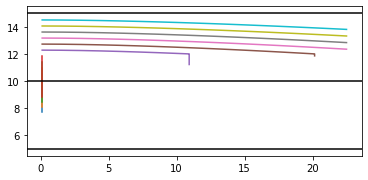

In [60]:
zstart = np.linspace(10.5, 14.5, 10)
for zs in zstart:
    trace = tt.timtrace(ml, xstart=0.1, ystart=.1, zstart=zs, 
                     tstartend=[0, 100], tstartoffset=0.01, tstep=5, 
                     nstepmax=40, hstepmax=2, silent=True)
    xyzt = trace['xyzt']
    plt.plot(xyzt[:, 0], xyzt[:, 2])
for y in [5, 10, 15]:
    plt.axhline(y, color='k')
plt.axis('scaled');

In [5]:
ml = ModelMaq(kaq=[k], z=[H, 0], Saq=[Ss], tmin=0.01, tmax=1000, M=10)
w = Well(ml, xw=0, yw=0, tsandQ=[(0, -Q), (100, Q), (200, -Q)], rw=0.3)
ml.solve()
trace = timtrace(ml, xstart=0.3, ystart=0, zstart=0, 
                 tstartend=[0, 100, 200, 400], tstartoffset=0.01, deltlist=10, 
                 nstepmax=120, hstepmax=2, correctionstep=True)
xyzt = trace['trace']

1.44

Signature:
timtrace(
    ml,
    xstart,
    ystart,
    zstart,
    tstartend,
    tstartoffset,
    deltlist,
    nstepmax=100,
    hstepmax=10,
    silent=False,
    correctionstep=True,
)
Docstring:
Compute a pathline by numerical integration of the velocity vector.
Pathline is broken up in sections for which starting times are provided. 
Pathline is computed from first starting time + offset until second
starting time, then continued from second starting time + offset until 
third starting time, etc. 

Parameters
----------
model : Model object
    model
xstart : float
    x-coordinate of starting location of pathline
ystart : float
    y-coordinate of starting location of pathline
zstart : float
    z-coordinate of starting location of pathline
tstartend : list
    list of starting times of pathline. last entry is the ending time.
tstartoffset : float
    time after starting time when pathline is started. this value can not
    be smaller than tmin.
deltlist : scalar or list
    

Pathlines are computed through numerical integration of the velocity vector.
Pathline is broken up in sections for which starting times are provided. 
Pathline is computed from first starting time + offset until second
starting time, then continued from second starting time + offset until 
third starting time, etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ttim import *

Start well with `tsandQ=[(0, -Q), (100, Q), (200, -Q)]`

In [2]:
Q = 100
npor = 0.3
k = 10
H = 10
T = k * H
Ss = 1e-4
S = Ss * H
ml = ModelMaq(kaq=[k], z=[H, 0], Saq=[Ss], tmin=0.01, tmax=1000, M=10)
w = Well(ml, xw=0, yw=0, tsandQ=[(0, -Q), (100, Q), (200, -Q)], rw=0.3)
ml.solve()
trace = timtrace(ml, xstart=0.3, ystart=0, zstart=0, 
                 tstartend=[0, 100, 200, 400], tstartoffset=0.01, deltlist=10, 
                 nstepmax=120, hstepmax=2, correctionstep=True)
xyzt = trace['trace']

self.neq  1
solution complete
reached maximum time tmax
reached maximum time tmax
reached maximum time tmax


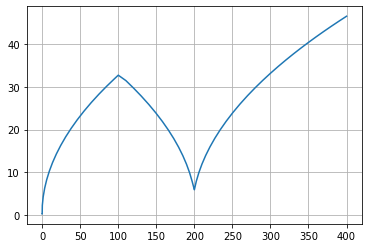

In [3]:
plt.plot(xyzt[:, 3], xyzt[:, 0])
plt.grid()

In [4]:
trace['status'], trace['message']

([1, 1, 1],
 ['reached maximum time tmax',
  'reached maximum time tmax',
  'reached maximum time tmax'])

#### Terminates at well

In [5]:
ml = ModelMaq(kaq=[k], z=[H, 0], Saq=[Ss], tmin=0.01, tmax=1000, M=10)
w = Well(ml, xw=0, yw=0, tsandQ=[(0, -Q), (100, Q)], rw=0.3, label='testwell')
ml.solve()
trace = timtrace(ml, xstart=0.3, ystart=0, zstart=0, 
                 tstartend=[0, 100, 300], tstartoffset=0.01, deltlist=10, 
                 nstepmax=120, hstepmax=2, correctionstep=True)
xyzt = trace['trace']
print(trace['status'], trace['message'])
print(xyzt[-3:])

self.neq  1
solution complete
reached maximum time tmax
reached well element with label: testwell
[1, 2] ['reached maximum time tmax', 'reached well element with label: testwell']
[[  3.8943918    0.           0.         201.42194579]
 [  1.8943918    0.           0.         202.38286201]
 [  0.           0.           0.         203.05932345]]


#### Compare to numerical integration of velocity from Theis equation
\begin{equation}
Q_r = -T\frac{\partial h}{\partial r} = -T\frac{\text{d} h}{\text{d} u}\frac{\partial u}{\partial r} = -\frac{Q}{2\pi} \frac{1}{r}\exp(-u)
\end{equation}
\begin{equation}
u =  \frac{S r^2}{4T(t-t_0)}
\end{equation}

In [6]:
def vxytheis(t, xy):
    Q = -100
    npor = 0.3
    k = 10
    H = 10
    Ss = 1e-4
    T = k * H
    S = Ss * H
    x, y = xy
    r = np.sqrt(x ** 2 + y ** 2)
    u = S * r ** 2 / (4 * T * t)
    Qr = -Q / (2 * np.pi) / r * np.exp(-u)
    vr = Qr / (H * npor)
    vx = vr * x / r
    vy = vr * y / r
    return np.array([vx, vy])

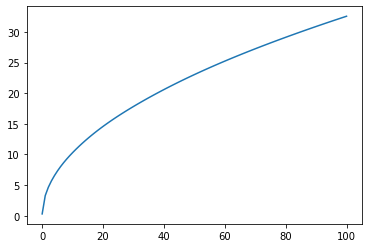

In [7]:
from scipy.integrate import solve_ivp
t = np.linspace(0.01, 100, 100)
path0 = solve_ivp(vxytheis, (0.01, 100), y0=[0.3, 0], t_eval=t)
plt.plot(path0.t, path0.y[0]);

#### Velocities in multi-layer system

In [61]:
Q = 100
npor = 0.3
k0 = 10
k1 = 40
H = 10
Hstar = 2
c = 100
T = k * H
Ss = 1e-4
S = Ss * H
ml = tt.ModelMaq(kaq=[k0, k1], z=[2 * H + Hstar, H + Hstar, H, 0], c=[c], Saq=[Ss], tmin=0.01, tmax=10000, M=10)
w = tt.Well(ml, xw=0, yw=0, tsandQ=[(0, -Q)], layers=0, rw=0.3)
ml.solve()

self.neq  1
solution complete


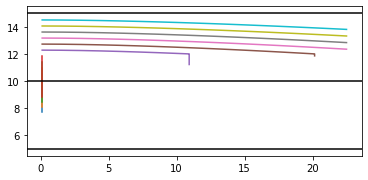

In [62]:
zstart = np.linspace(10.5, 14.5, 10)
for zs in zstart:
    trace = tt.timtrace(ml, xstart=0.1, ystart=.1, zstart=zs, 
                     tstartend=[0, 100], tstartoffset=0.01, tstep=5, 
                     nstepmax=40, hstepmax=2, silent=True)
    xyzt = trace['xyzt']
    plt.plot(xyzt[:, 0], xyzt[:, 2])
for y in [5, 10, 15]:
    plt.axhline(y, color='k')
plt.axis('scaled');

In [64]:
for z in np.arange(13, 22):
    trace = tt.timtrace(ml, xstart=0.3, ystart=0, zstart=z, 
                     tstartend=[0, 1000], tstartoffset=0.01, deltlist=10, 
                     nstepmax=500, hstepmax=2, correctionstep=True, silent=True)
    xyzt = trace['trace']
    plt.plot(xyzt[:, 0], xyzt[:, 2])

TypeError: timtrace() got an unexpected keyword argument 'deltlist'

#### Model3D

In [79]:
Q = 100
npor = 0.3
k = 10
H = 10
Hstar = 2
c = 1000
T = k * H
#Ss = 1e-4
Ss = 1e-8
S = Ss * H
ml = tt.Model3D(kaq=10, z=[20, 15, 10, 5, 0], tmin=0.01, tmax=1000)
w = tt.Well(ml, xw=0, yw=0, tsandQ=[(0, -Q), (100, Q)], layers=1, rw=0.1)
ml.solve()

self.neq  1
solution complete


In [ ]:
ml.head(1

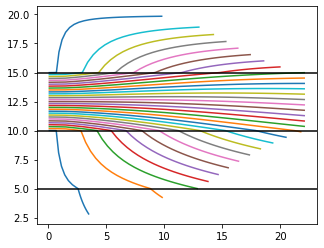

In [69]:
zstart = np.linspace(10.01, 14.99, 31)
for zs in zstart:
    trace = tt.timtrace(ml, xstart=0.1, ystart=.1, zstart=zs, 
                     tstartend=[0, 100], tstartoffset=0.01, tstep=5, 
                     nstepmax=40, hstepmax=2, silent=True)
    xyzt = trace['xyzt']
    plt.plot(xyzt[:, 0], xyzt[:, 2])
for y in [5, 10, 15]:
    plt.axhline(y, color='k')
plt.axis('scaled');

In [81]:
ml.head(0, 0, 100)

Warning, some of the times are smaller than tmin after
a change in boundary condition. nans are substituted


array([[nan],
       [nan],
       [nan],
       [nan]])

In [83]:
h = ml.headalongline(np.linspace(0, 20, 100), np.zeros(100), t=100 - 1e-6)

In [88]:
w.headinside(99)

array([[1.90565058]])

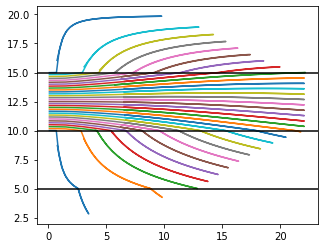

In [12]:
zstart = np.linspace(10.01, 14.99, 31)
for zs in zstart:
    trace = timtrace(ml, xstart=0.1, ystart=0.1, zstart=zs, 
                     tstartend=[0, 100, 200], tstartoffset=0.01, deltlist=5, 
                     nstepmax=40, hstepmax=2, silent=True, correctionstep=True)
    xyzt = trace['trace']
    plt.plot(xyzt[:, 0], xyzt[:, 2])
for y in [5, 10, 15]:
    plt.axhline(y, color='k')
plt.axis('scaled');